In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

# Load the dataset
file_path = "/content/drive/MyDrive/data.csv"
data = pd.read_csv(file_path, encoding='latin1')

# Inspect the data
print(data.head())
print(data.info())
print(data.describe().T)

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo   

In [3]:
data_no_duplicates = data.copy()  # Create a copy of the data
data_no_duplicates = data.drop_duplicates()  # Drop duplicates

# Print the shape of the original and the no-duplicates DataFrame
print(data.shape)  # Correct way to access shape
print(data_no_duplicates.shape)  # Correct way to access shape

(541909, 8)
(536641, 8)


In [4]:
# Step 1: Create a copy to preserve original data
data_filled = data_no_duplicates.copy()

# Step 2: Create a mapping of StockCode to the most common Description
stockcode_to_description = (
    data_filled.groupby("StockCode")["Description"]
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
)

# Step 3: Fill missing Descriptions using StockCode mapping
data_filled["Description"] = data_filled["Description"].fillna(data_filled["StockCode"].map(stockcode_to_description))

# Step 4: If any missing values remain, fill with most common description in the dataset
if data_filled["Description"].isnull().sum() > 0:
    most_common_description = data_filled["Description"].mode()[0]
    data_filled["Description"] = data_filled["Description"].fillna(most_common_description)

# Step 5: Verify if all missing values are filled
print("Missing values in Description after filling:", data_filled["Description"].isnull().sum())  # Should be 0

# Display sample rows with filled descriptions
print(data_filled.head())
print(data_filled.isnull().sum())

Missing values in Description after filling: 0
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  
InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135037
Country     

In [5]:
# Step 1: Create a copy to preserve original data
data_imputation = data_filled.copy()

# Step 2: Fill missing CustomerID using forward and backward fill within the same InvoiceNo
data_imputation["CustomerID"] = (
    data_imputation.groupby("InvoiceNo")["CustomerID"]
    .transform(lambda x: x.ffill().bfill())
)

# Step 3: If there are still missing values, interpolate them (based on previous & next values)
data_imputation["CustomerID"] = data_imputation["CustomerID"].interpolate()

# Step 4: Convert CustomerID to integer (optional, only if there are no remaining NaNs)
if data_imputation["CustomerID"].isnull().sum() == 0:
    data_imputation["CustomerID"] = data_imputation["CustomerID"].astype(int)

# Step 5: Verify if all missing values are filled
print("Missing values in CustomerID after filling:", data_imputation["CustomerID"].isnull().sum())  # Should be 0

# Display sample rows with filled CustomerID
print(data_imputation.head())
print(data_imputation.isnull().sum())

Missing values in CustomerID after filling: 0
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55       17850  United Kingdom  
1  12/1/2010 8:26       3.39       17850  United Kingdom  
2  12/1/2010 8:26       2.75       17850  United Kingdom  
3  12/1/2010 8:26       3.39       17850  United Kingdom  
4  12/1/2010 8:26       3.39       17850  United Kingdom  
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


In [6]:
# Create a copy of the original DataFrame
data_no_negatives = data_imputation.copy()

# Remove rows where 'Quantity' or 'UnitPrice' are less than or equal to zero
data_no_negatives = data_no_negatives[(data_no_negatives['Quantity'] > 0) & (data_no_negatives['UnitPrice'] > 0)]

# Create a copy of the original DataFrame for the negatives
data_only_negatives = data_imputation.copy()

# Filter out rows where 'Quantity' or 'UnitPrice' are greater than zero (keep values that are 0 or less)
data_only_negatives = data_only_negatives[(data_only_negatives['Quantity'] <= 0) | (data_only_negatives['UnitPrice'] <= 0)]

# Check the first few rows of each DataFrame to confirm
print("Data without negatives (data_no_negatives):")
print(data_no_negatives.head())

print("\nData with only negatives (data_only_negatives):")
print(data_only_negatives.head())

Data without negatives (data_no_negatives):
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55       17850  United Kingdom  
1  12/1/2010 8:26       3.39       17850  United Kingdom  
2  12/1/2010 8:26       2.75       17850  United Kingdom  
3  12/1/2010 8:26       3.39       17850  United Kingdom  
4  12/1/2010 8:26       3.39       17850  United Kingdom  

Data with only negatives (data_only_negatives):
    InvoiceNo StockCode                       Description  Quantity  \
141   C536379         D                          

In [7]:
# Create a copy of data_no_negatives for data_charges
data_charges = data_no_negatives.copy()

# Filter rows where 'Description' contains 'Bank Charges', 'POSTAGE', or 'PACKING CHARGE'
data_charges = data_charges[data_charges['Description'].str.contains('Bank Charges|POSTAGE|PACKING CHARGE', case=False, na=False)]

# Create a copy of data_no_negatives for data_manual
data_manual = data_no_negatives.copy()

# Filter rows where 'Description' contains 'Mannual'
data_manual = data_manual[data_manual['Description'].str.contains('Manual', case=False, na=False)]

# Create a copy of data_no_negatives for data_dotcompostage
data_dotcompostage = data_no_negatives.copy()

# Filter rows where 'Description' contains 'DOTCOM POSTAGE'
data_dotcompostage = data_dotcompostage[data_dotcompostage['Description'].str.contains('DOTCOM POSTAGE', case=False, na=False)]

# Create a copy of data_no_negatives for data_filtered
data_filtered = data_no_negatives.copy()

# Remove rows where 'Description' contains any of the mentioned descriptions (charges, manual, or dotcom postage)
data_filtered = data_filtered[~data_filtered['Description'].str.contains('Bank Charges|POSTAGE|PACKING CHARGE|Manual|DOTCOM POSTAGE', case=False, na=False)]

# Print the first few rows of each DataFrame to confirm the filtering
print("Data with charges (data_charges):")
print(data_charges.head())

print("\nData with manual entries (data_manual):")
print(data_manual.head())

print("\nData with dotcom postage (data_dotcompostage):")
print(data_dotcompostage.head())

print("\nData with filtered descriptions (data_filtered):")
print(data_filtered.head())


Data with charges (data_charges):
     InvoiceNo StockCode     Description  Quantity      InvoiceDate  \
45      536370      POST         POSTAGE         3   12/1/2010 8:45   
386     536403      POST         POSTAGE         1  12/1/2010 11:27   
1123    536527      POST         POSTAGE         1  12/1/2010 13:04   
1814    536544       DOT  DOTCOM POSTAGE         1  12/1/2010 14:32   
3041    536592       DOT  DOTCOM POSTAGE         1  12/1/2010 17:06   

      UnitPrice  CustomerID         Country  
45        18.00       12583          France  
386       15.00       12791     Netherlands  
1123      18.00       12662         Germany  
1814     569.77       14079  United Kingdom  
3041     607.49       16789  United Kingdom  

Data with manual entries (data_manual):
     InvoiceNo StockCode Description  Quantity      InvoiceDate  UnitPrice  \
2239    536569         M      Manual         1  12/1/2010 15:35       1.25   
2250    536569         M      Manual         1  12/1/2010 15:35   

In [8]:
# Remove rows where 'Description' contains 'AMAZON FEE' or 'Adjust bad debt'
data_filtered = data_filtered[~data_filtered['Description'].str.contains('AMAZON FEE|Adjust bad debt', case=False, na=False)]

# Print the first few rows to confirm the removal
print("Updated data_filtered after removing 'AMAZON FEE' and 'Adjust bad debt' rows:")
print(data_filtered.head())

Updated data_filtered after removing 'AMAZON FEE' and 'Adjust bad debt' rows:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55       17850  United Kingdom  
1  12/1/2010 8:26       3.39       17850  United Kingdom  
2  12/1/2010 8:26       2.75       17850  United Kingdom  
3  12/1/2010 8:26       3.39       17850  United Kingdom  
4  12/1/2010 8:26       3.39       17850  United Kingdom  


In [9]:
# Remove rows where 'Quantity' is 74215 or 80995
data_filtered = data_filtered[~data_filtered['Quantity'].isin([74215, 80995])]

# Print the first few rows to confirm the removal
print("Updated data_filtered after removing rows with Quantity 74215 and 80995:")
print(data_filtered.head())

Updated data_filtered after removing rows with Quantity 74215 and 80995:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55       17850  United Kingdom  
1  12/1/2010 8:26       3.39       17850  United Kingdom  
2  12/1/2010 8:26       2.75       17850  United Kingdom  
3  12/1/2010 8:26       3.39       17850  United Kingdom  
4  12/1/2010 8:26       3.39       17850  United Kingdom  


In [10]:
data_total_price = data_filtered.copy()

# Create TotalPrice = Quantity * UnitPrice
data_total_price['TotalPrice'] = data_total_price['Quantity'] * data_total_price['UnitPrice']

print(data_total_price.head())
print(data_total_price.isnull().sum())
print(data_total_price.info())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  
0  12/1/2010 8:26       2.55       17850  United Kingdom       15.30  
1  12/1/2010 8:26       3.39       17850  United Kingdom       20.34  
2  12/1/2010 8:26       2.75       17850  United Kingdom       22.00  
3  12/1/2010 8:26       3.39       17850  United Kingdom       20.34  
4  12/1/2010 8:26       3.39       17850  United Kingdom       20.34  
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
Total

In [11]:
import numpy as np
import pandas as pd
# Copy dataset
data_capped_0_1_99 = data_total_price.copy()

# Define capping limits based on percentiles
for col in ['Quantity', 'UnitPrice', 'TotalPrice']:
    lower_bound = np.percentile(data_total_price[col], 0.1)
    upper_bound = np.percentile(data_total_price[col], 99.00)

    # Apply capping
    data_capped_0_1_99[col] = np.clip(data_total_price[col], lower_bound, upper_bound)

# Display summary
print("=== Percentile-Based Capping (0.1% - 99%) Applied Successfully ===")
print(data_capped_0_1_99.describe())

=== Percentile-Based Capping (0.1% - 99%) Applied Successfully ===
            Quantity      UnitPrice     CustomerID     TotalPrice
count  522698.000000  522698.000000  522698.000000  522698.000000
mean        8.863809       3.186862   15279.932982      16.634413
std        15.339762       3.119251    1651.394970      26.133503
min         1.000000       0.120000   12347.000000       0.360000
25%         1.000000       1.250000   13993.000000       3.900000
50%         4.000000       2.080000   15159.000000       9.900000
75%        12.000000       4.130000   16713.000000      17.700000
max       100.000000      16.630000   18287.000000     179.000000


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Make a copy of the data
data_capped_transformed = data_capped_0_1_99.copy()

# Apply log transformation
data_capped_transformed['log_Quantity'] = np.log1p(data_capped_transformed['Quantity'])
data_capped_transformed['log_UnitPrice'] = np.log1p(data_capped_transformed['UnitPrice'])
data_capped_transformed['log_TotalPrice'] = np.log1p(data_capped_transformed['TotalPrice'])

print("=== Log Transformation on Percentile-Based Capped data (0.1% - 99%) Applied Successfully ===")
print(data_capped_transformed.describe())


=== Log Transformation on Percentile-Based Capped data (0.1% - 99%) Applied Successfully ===
            Quantity      UnitPrice     CustomerID     TotalPrice  \
count  522698.000000  522698.000000  522698.000000  522698.000000   
mean        8.863809       3.186862   15279.932982      16.634413   
std        15.339762       3.119251    1651.394970      26.133503   
min         1.000000       0.120000   12347.000000       0.360000   
25%         1.000000       1.250000   13993.000000       3.900000   
50%         4.000000       2.080000   15159.000000       9.900000   
75%        12.000000       4.130000   16713.000000      17.700000   
max       100.000000      16.630000   18287.000000     179.000000   

        log_Quantity  log_UnitPrice  log_TotalPrice  
count  522698.000000  522698.000000   522698.000000  
mean        1.713315       1.228585        2.327104  
std         0.965880       0.607250        0.986549  
min         0.693147       0.113329        0.307485  
25%         0.6

In [13]:
# Drop the original columns to avoid confusion
data_capped_transformed_1 = data_capped_transformed.drop(['Quantity', 'UnitPrice', 'TotalPrice'], axis=1)

# Check the updated dataframe
data_capped_transformed_1.head()

,InvoiceNo,StockCode,Description,InvoiceDate,CustomerID,Country,log_Quantity,log_UnitPrice,log_TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,12/1/2010 8:26,17850,United Kingdom,1.945910,1.266948,2.791165
1,536365,71053,WHITE METAL LANTERN,12/1/2010 8:26,17850,United Kingdom,1.945910,1.479329,3.060583
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,12/1/2010 8:26,17850,United Kingdom,2.197225,1.321756,3.135494
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,12/1/2010 8:26,17850,United Kingdom,1.945910,1.479329,3.060583
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,12/1/2010 8:26,17850,United Kingdom,1.945910,1.479329,3.060583


In [14]:
# Copy the data for invoice date feature extraction
data_capped_transformed_1dt = data_capped_transformed_1.copy()

# Convert InvoiceDate to datetime (format: %m/%d/%Y %H:%M)
data_capped_transformed_1dt['InvoiceDate'] = pd.to_datetime(data_capped_transformed_1dt['InvoiceDate'], format='%m/%d/%Y %H:%M')

# Extract additional features from InvoiceDate
data_capped_transformed_1dt['DayOfWeek'] = data_capped_transformed_1dt['InvoiceDate'].dt.dayofweek  # 0=Monday, 6=Sunday
data_capped_transformed_1dt['HourOfDay'] = data_capped_transformed_1dt['InvoiceDate'].dt.hour        # Hour in 24-hour format
data_capped_transformed_1dt['Month'] = data_capped_transformed_1dt['InvoiceDate'].dt.month           # Month (1-12)
data_capped_transformed_1dt['Year'] = data_capped_transformed_1dt['InvoiceDate'].dt.year             # Year

# Check the newly extracted features
print(data_capped_transformed_1dt[['InvoiceDate', 'DayOfWeek', 'HourOfDay', 'Month', 'Year']].head())
print(data_capped_transformed_1dt.head())
print(data_capped_transformed_1dt.info())

          InvoiceDate  DayOfWeek  HourOfDay  Month  Year
0 2010-12-01 08:26:00          2          8     12  2010
1 2010-12-01 08:26:00          2          8     12  2010
2 2010-12-01 08:26:00          2          8     12  2010
3 2010-12-01 08:26:00          2          8     12  2010
4 2010-12-01 08:26:00          2          8     12  2010
  InvoiceNo StockCode                          Description  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER   
1    536365     71053                  WHITE METAL LANTERN   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.   

          InvoiceDate  CustomerID         Country  log_Quantity  \
0 2010-12-01 08:26:00       17850  United Kingdom      1.945910   
1 2010-12-01 08:26:00       17850  United Kingdom      1.945910   
2 2010-12-01 08:26:00       17850  United Kingdom      2.197225   
3 2010-12-01 08:2

In [15]:
# Make a copy of the data to preserve the original data
data_rfm_captransformed_1dt = data_capped_transformed_1dt.copy()

# Calculate Recency: Days since last purchase
# Most recent date in the dataset
max_date = data_rfm_captransformed_1dt['InvoiceDate'].max()

# Recency calculation (days since last purchase)
data_rfm = data_rfm_captransformed_1dt.groupby('CustomerID').agg(
    recency=('InvoiceDate', lambda x: (max_date - x.max()).days),
    frequency=('InvoiceNo', 'nunique'),
    monetary=('log_TotalPrice', 'sum')
).reset_index()

# Merge the calculated RFM columns with the original data
data_rfm_captransformed_1dt = data_rfm_captransformed_1dt.merge(
    data_rfm[['CustomerID', 'recency', 'frequency', 'monetary']],
    on='CustomerID',
    how='left'
)

# Show the first few rows with the original and new columns
print(data_rfm_captransformed_1dt.head())
print(data_rfm.head())

  InvoiceNo StockCode                          Description  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER   
1    536365     71053                  WHITE METAL LANTERN   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.   

          InvoiceDate  CustomerID         Country  log_Quantity  \
0 2010-12-01 08:26:00       17850  United Kingdom      1.945910   
1 2010-12-01 08:26:00       17850  United Kingdom      1.945910   
2 2010-12-01 08:26:00       17850  United Kingdom      2.197225   
3 2010-12-01 08:26:00       17850  United Kingdom      1.945910   
4 2010-12-01 08:26:00       17850  United Kingdom      1.945910   

   log_UnitPrice  log_TotalPrice  DayOfWeek  HourOfDay  Month  Year  recency  \
0       1.266948        2.791165          2          8     12  2010        2   
1       1.479329        3.060583          2          8     12  2

In [16]:
# Function to assign RFM score based on percentile ranges
def rfm_score(data, column, ascending=False):
    """
    Assign scores for Recency, Frequency, and Monetary values based on percentiles.
    Higher scores are assigned for better customer behavior (e.g., more frequent, recent).
    """
    if ascending:
        return pd.qcut(data[column], 5, labels=[5, 4, 3, 2, 1])
    else:
        return pd.qcut(data[column], 5, labels=[1, 2, 3, 4, 5])

# Assigning RFM scores
data_rfm['recency_score'] = rfm_score(data_rfm, 'recency', ascending=True)  # lower recency is better
data_rfm['frequency_score'] = rfm_score(data_rfm, 'frequency', ascending=False)  # higher frequency is better
data_rfm['monetary_score'] = rfm_score(data_rfm, 'monetary', ascending=False)  # higher monetary is better

# Combine the scores into a single 'RFM_Score' column
data_rfm['RFM_Score'] = data_rfm['recency_score'].astype(str) + data_rfm['frequency_score'].astype(str) + data_rfm['monetary_score'].astype(str)
print(data_rfm[['CustomerID', 'recency', 'frequency', 'monetary', 'recency_score', 'frequency_score', 'monetary_score', 'RFM_Score']].head())

data_rfm_captransformed_2dt = data_rfm_captransformed_1dt.copy()
# Merge the newly calculated RFM scores into the original dataframe
data_rfm_captransformed_2dt = data_rfm_captransformed_2dt.merge(
    data_rfm[['CustomerID', 'recency_score', 'frequency_score', 'monetary_score', 'RFM_Score']],
    on='CustomerID',
    how='left'
)

# Display the top 10 rows of the resulting DataFrame with the new columns
print(data_rfm_captransformed_2dt[['CustomerID', 'recency', 'frequency', 'monetary', 'recency_score', 'frequency_score', 'monetary_score', 'RFM_Score']].head())
print(data_rfm_captransformed_2dt.head())
print(data_rfm_captransformed_2dt.info())

   CustomerID  recency  frequency    monetary recency_score frequency_score  \
0       12347        1          7  549.293523             5               1   
1       12348       74          4  101.734541             1               1   
2       12349       18          1  212.358379             1               1   
3       12350      309          1   46.829722             1               1   
4       12352       35          7  224.592798             1               1   

  monetary_score RFM_Score  
0              5       515  
1              3       113  
2              4       114  
3              1       111  
4              4       114  
   CustomerID  recency  frequency    monetary recency_score frequency_score  \
0       17850        2         47  851.659369             4               5   
1       17850        2         47  851.659369             4               5   
2       17850        2         47  851.659369             4               5   
3       17850        2         47  

In [17]:
# Segmenting the customers into groups based on their RFM score
def segment_customers(rfm_score):
    if rfm_score == '555':
        return 'Best Customers'
    elif rfm_score in ['554', '545', '544']:
        return 'Loyal Customers'
    elif rfm_score in ['553', '443', '444']:
        return 'Potential Loyalist'
    elif rfm_score in ['123', '124']:
        return 'New Customers'
    else:
        return 'Other'

# Assign segments to the 'Segment' column
data_rfm['Segment'] = data_rfm['RFM_Score'].apply(segment_customers)
# Display the segmented customers
print(data_rfm[['CustomerID', 'RFM_Score', 'Segment']].head())

data_rfm_captransformed_3dt = data_rfm_captransformed_2dt.copy()
# Merge the newly created 'Segment' column into the original dataframe
data_rfm_captransformed_3dt = data_rfm_captransformed_3dt.merge(
    data_rfm[['CustomerID', 'Segment']],
    on='CustomerID',
    how='left'
)

# Display the first few rows with the added 'Segment' column
print(data_rfm_captransformed_3dt[['CustomerID', 'recency', 'frequency', 'monetary', 'recency_score', 'frequency_score', 'monetary_score', 'RFM_Score', 'Segment']].head())


   CustomerID RFM_Score Segment
0       12347       515   Other
1       12348       113   Other
2       12349       114   Other
3       12350       111   Other
4       12352       114   Other
   CustomerID  recency  frequency    monetary recency_score frequency_score  \
0       17850        2         47  851.659369             4               5   
1       17850        2         47  851.659369             4               5   
2       17850        2         47  851.659369             4               5   
3       17850        2         47  851.659369             4               5   
4       17850        2         47  851.659369             4               5   

  monetary_score RFM_Score Segment  
0              5       455   Other  
1              5       455   Other  
2              5       455   Other  
3              5       455   Other  
4              5       455   Other  


In [18]:
# Grouping by customer segment
segment_summary = data_rfm.groupby('Segment').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean',
    'CustomerID': 'count'
}).reset_index()

# Displaying the summary
print(segment_summary)

              Segment    recency  frequency    monetary  CustomerID
0      Best Customers   0.571429  42.207143  961.428799         280
1     Loyal Customers   0.574176  30.434066  273.452933         364
2       New Customers  20.845238  19.607143  137.902268          84
3               Other  13.570810  21.731117  161.804270        5084
4  Potential Loyalist   1.201835  31.944954  123.292006         109


In [19]:
data_rfm_captransformed_3dt1 = data_rfm_captransformed_3dt.copy()  # Create a copy of the data
data_rfm_captransformed_3dt1 = data_rfm_captransformed_3dt1.drop_duplicates()  # Drop duplicates

# Log tranformed capped data with no duplicates
print(data_rfm_captransformed_3dt1.head())
print(data_rfm_captransformed_3dt1.info())
print(data_rfm_captransformed_3dt1.shape)
print(data_rfm_captransformed_3dt1.describe().T)
print(data_rfm_captransformed_3dt1.nunique())
print(data_rfm_captransformed_3dt1.isnull().sum())
print(data_rfm_captransformed_3dt1.duplicated().sum())
print(data_rfm_captransformed_3dt1[~data_rfm_captransformed_3dt1.isnull().any(axis=1) & ~data_rfm_captransformed_3dt1.duplicated()])
print((data_rfm_captransformed_3dt1['log_Quantity'] < 0).sum(), (data_rfm_captransformed_3dt1['log_UnitPrice'] < 0).sum())
print(data_rfm_captransformed_3dt1.columns)


  InvoiceNo StockCode                          Description  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER   
1    536365     71053                  WHITE METAL LANTERN   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.   

          InvoiceDate  CustomerID         Country  log_Quantity  \
0 2010-12-01 08:26:00       17850  United Kingdom      1.945910   
1 2010-12-01 08:26:00       17850  United Kingdom      1.945910   
2 2010-12-01 08:26:00       17850  United Kingdom      2.197225   
3 2010-12-01 08:26:00       17850  United Kingdom      1.945910   
4 2010-12-01 08:26:00       17850  United Kingdom      1.945910   

   log_UnitPrice  log_TotalPrice  DayOfWeek  ...  Month  Year  recency  \
0       1.266948        2.791165          2  ...     12  2010        2   
1       1.479329        3.060583          2  ...     12  2010        2   
2 

In [20]:
import pickle

# Save the dataframe as a pickle file to Google Drive
with open('/content/drive/My Drive/data_rfm_captransformed_3dt1.pkl', 'wb') as f:
    pickle.dump(data_rfm_captransformed_3dt1, f)


In [21]:
# Save the dataframe as a CSV file to Google Drive
data_rfm_captransformed_3dt1.to_csv('/content/drive/My Drive/data_rfm_captransformed_3dt1.csv', index=False)


In [22]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Create a copy of the original dataframe
data_rfm_captransformed_3dt1_encoded = data_rfm_captransformed_3dt1.copy()

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode 'StockCode' in the copied dataframe
data_rfm_captransformed_3dt1_encoded['StockCode'] = label_encoder.fit_transform(data_rfm_captransformed_3dt1_encoded['StockCode'])

# Encode 'CustomerID' in the copied dataframe
data_rfm_captransformed_3dt1_encoded['CustomerID'] = label_encoder.fit_transform(data_rfm_captransformed_3dt1_encoded['CustomerID'])

# Check the first few rows to ensure the encoding worked
print(data_rfm_captransformed_3dt1_encoded[['StockCode', 'CustomerID']].head())


   StockCode  CustomerID
0       3405        5498
1       2727        5498
2       2951        5498
3       2895        5498
4       2894        5498


In [23]:
print(data_rfm_captransformed_3dt1_encoded.head())
print(data_rfm_captransformed_3dt1_encoded.info())
print(data_rfm_captransformed_3dt1_encoded.duplicated().sum())

  InvoiceNo  StockCode                          Description  \
0    536365       3405   WHITE HANGING HEART T-LIGHT HOLDER   
1    536365       2727                  WHITE METAL LANTERN   
2    536365       2951       CREAM CUPID HEARTS COAT HANGER   
3    536365       2895  KNITTED UNION FLAG HOT WATER BOTTLE   
4    536365       2894       RED WOOLLY HOTTIE WHITE HEART.   

          InvoiceDate  CustomerID         Country  log_Quantity  \
0 2010-12-01 08:26:00        5498  United Kingdom      1.945910   
1 2010-12-01 08:26:00        5498  United Kingdom      1.945910   
2 2010-12-01 08:26:00        5498  United Kingdom      2.197225   
3 2010-12-01 08:26:00        5498  United Kingdom      1.945910   
4 2010-12-01 08:26:00        5498  United Kingdom      1.945910   

   log_UnitPrice  log_TotalPrice  DayOfWeek  ...  Month  Year  recency  \
0       1.266948        2.791165          2  ...     12  2010        2   
1       1.479329        3.060583          2  ...     12  2010        2

In [24]:
print(data_rfm_captransformed_3dt1_encoded.nunique())

InvoiceNo          19776
StockCode           3913
Description         4018
InvoiceDate        18334
CustomerID          5921
Country               38
log_Quantity         100
log_UnitPrice        411
log_TotalPrice      2619
DayOfWeek              6
HourOfDay             15
Month                 12
Year                   2
recency              140
frequency             81
monetary            5919
recency_score          5
frequency_score        5
monetary_score         5
RFM_Score            119
Segment                5
dtype: int64


In [25]:
from sklearn.preprocessing import StandardScaler

# Create a copy of the data for scaling
data_rfm_captransformed_3dt1_scaled = data_rfm_captransformed_3dt1_encoded.copy()

# Initialize the StandardScaler
scaler = StandardScaler()

# Apply scaling to 'log_Quantity' and 'log_UnitPrice'
data_rfm_captransformed_3dt1_scaled[['log_Quantity', 'log_UnitPrice']] = scaler.fit_transform(
    data_rfm_captransformed_3dt1_scaled[['log_Quantity', 'log_UnitPrice']]
)

# Verify the transformation
print(data_rfm_captransformed_3dt1_scaled[['log_Quantity', 'log_UnitPrice']].head())
print(data_rfm_captransformed_3dt1_scaled[['log_Quantity', 'log_UnitPrice']].describe())


   log_Quantity  log_UnitPrice
0      0.240835       0.063173
1      0.240835       0.412916
2      0.501034       0.153430
3      0.240835       0.412916
4      0.240835       0.412916
       log_Quantity  log_UnitPrice
count  5.226950e+05   5.226950e+05
mean   3.145069e-16   2.690491e-16
std    1.000001e+00   1.000001e+00
min   -1.056213e+00  -1.836567e+00
25%   -1.056213e+00  -6.877807e-01
50%   -1.075315e-01  -1.706972e-01
75%    8.817575e-01   6.694433e-01
max    3.004403e+00   2.702370e+00


In [27]:
print(data_rfm_captransformed_3dt1_scaled.head())
print(data_rfm_captransformed_3dt1_scaled.info())
print(data_rfm_captransformed_3dt1_scaled.duplicated().sum())
print(data_rfm_captransformed_3dt1_scaled.nunique())
print(data_rfm_captransformed_3dt1_scaled.describe())

  InvoiceNo  StockCode                          Description  \
0    536365       3405   WHITE HANGING HEART T-LIGHT HOLDER   
1    536365       2727                  WHITE METAL LANTERN   
2    536365       2951       CREAM CUPID HEARTS COAT HANGER   
3    536365       2895  KNITTED UNION FLAG HOT WATER BOTTLE   
4    536365       2894       RED WOOLLY HOTTIE WHITE HEART.   

          InvoiceDate  CustomerID         Country  log_Quantity  \
0 2010-12-01 08:26:00        5498  United Kingdom      0.240835   
1 2010-12-01 08:26:00        5498  United Kingdom      0.240835   
2 2010-12-01 08:26:00        5498  United Kingdom      0.501034   
3 2010-12-01 08:26:00        5498  United Kingdom      0.240835   
4 2010-12-01 08:26:00        5498  United Kingdom      0.240835   

   log_UnitPrice  log_TotalPrice  DayOfWeek  ...  Month  Year  recency  \
0       0.063173        2.791165          2  ...     12  2010        2   
1       0.412916        3.060583          2  ...     12  2010        2

In [31]:
from sklearn.model_selection import train_test_split

# Selecting the relevant features (X) and the target (y)
X = data_rfm_captransformed_3dt1_scaled[['log_Quantity', 'log_UnitPrice', 'StockCode', 'CustomerID']]
y = data_rfm_captransformed_3dt1_scaled['log_TotalPrice']

# Splitting the data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Checking the shapes of the resulting datasets
print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")


Training data shape: (418156, 4), Test data shape: (104539, 4)


In [33]:
# Importing the necessary library
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Initialize the model
lr_model = LinearRegression()

# Train the model
lr_model.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test)

# Calculate evaluation metrics
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

# Print results
print("Linear Regression Model Performance:")
print(f'Mean Squared Error (MSE): {mse_lr}')
print(f'Root Mean Squared Error (RMSE): {rmse_lr}')
print(f'Mean Absolute Error (MAE): {mae_lr}')
print(f'R² (Coefficient of Determination): {r2_lr}')


Linear Regression Model Performance:
Mean Squared Error (MSE): 0.0367209874469416
Root Mean Squared Error (RMSE): 0.191627209568322
Mean Absolute Error (MAE): 0.1403856673166202
R² (Coefficient of Determination): 0.9618702432405458


In [34]:
# Importing the necessary library
from sklearn.linear_model import Ridge

# Initialize the Ridge model
ridge_model = Ridge(alpha=1.0)

# Train the model
ridge_model.fit(X_train, y_train)

# Make predictions
y_pred_ridge = ridge_model.predict(X_test)

# Calculate evaluation metrics
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

# Print results
print("\nRidge Regression Model Performance:")
print(f'Mean Squared Error (MSE): {mse_ridge}')
print(f'Root Mean Squared Error (RMSE): {rmse_ridge}')
print(f'Mean Absolute Error (MAE): {mae_ridge}')
print(f'R² (Coefficient of Determination): {r2_ridge}')



Ridge Regression Model Performance:
Mean Squared Error (MSE): 0.03672097725356385
Root Mean Squared Error (RMSE): 0.19162718297142461
Mean Absolute Error (MAE): 0.14038562689564069
R² (Coefficient of Determination): 0.9618702538249837


In [35]:
# Importing the necessary library
from sklearn.linear_model import Lasso

# Initialize the Lasso model
lasso_model = Lasso(alpha=0.1)

# Train the model
lasso_model.fit(X_train, y_train)

# Make predictions
y_pred_lasso = lasso_model.predict(X_test)

# Calculate evaluation metrics
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mse_lasso)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

# Print results
print("\nLasso Regression Model Performance:")
print(f'Mean Squared Error (MSE): {mse_lasso}')
print(f'Root Mean Squared Error (RMSE): {rmse_lasso}')
print(f'Mean Absolute Error (MAE): {mae_lasso}')
print(f'R² (Coefficient of Determination): {r2_lasso}')



Lasso Regression Model Performance:
Mean Squared Error (MSE): 0.07054939944619033
Root Mean Squared Error (RMSE): 0.26561136919603107
Mean Absolute Error (MAE): 0.2186281006270146
R² (Coefficient of Determination): 0.9267440331146961


In [36]:
# Importing the necessary library
from sklearn.linear_model import ElasticNet

# Initialize the ElasticNet model
elasticnet_model = ElasticNet(alpha=0.1, l1_ratio=0.5)

# Train the model
elasticnet_model.fit(X_train, y_train)

# Make predictions
y_pred_elasticnet = elasticnet_model.predict(X_test)

# Calculate evaluation metrics
mse_elasticnet = mean_squared_error(y_test, y_pred_elasticnet)
rmse_elasticnet = np.sqrt(mse_elasticnet)
mae_elasticnet = mean_absolute_error(y_test, y_pred_elasticnet)
r2_elasticnet = r2_score(y_test, y_pred_elasticnet)

# Print results
print("\nElasticNet Regression Model Performance:")
print(f'Mean Squared Error (MSE): {mse_elasticnet}')
print(f'Root Mean Squared Error (RMSE): {rmse_elasticnet}')
print(f'Mean Absolute Error (MAE): {mae_elasticnet}')
print(f'R² (Coefficient of Determination): {r2_elasticnet}')



ElasticNet Regression Model Performance:
Mean Squared Error (MSE): 0.06187153929444625
Root Mean Squared Error (RMSE): 0.24873990289948705
Mean Absolute Error (MAE): 0.2034388400381749
R² (Coefficient of Determination): 0.9357548119576306


In [37]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np


In [38]:
# Initialize Linear Regression model
lr_model = LinearRegression()

# Perform cross-validation
lr_cv_scores = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Compute the Mean Squared Error (MSE)
lr_cv_mse = -lr_cv_scores  # Negative because cross_val_score minimizes the score
lr_cv_rmse = np.sqrt(lr_cv_mse)  # RMSE is the square root of MSE

# Display the results
print(f"Linear Regression Model Cross-Validation Results:")
print(f"MSE: {lr_cv_mse.mean()}")
print(f"RMSE: {lr_cv_rmse.mean()}")
print(f"Standard Deviation of RMSE: {lr_cv_rmse.std()}")
print("=========================================")


Linear Regression Model Cross-Validation Results:
MSE: 0.03729967815383737
RMSE: 0.19313004139586779
Standard Deviation of RMSE: 0.0006821028278502832


In [39]:
# Initialize Ridge Regression model
ridge_model = Ridge()

# Perform cross-validation
ridge_cv_scores = cross_val_score(ridge_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Compute the Mean Squared Error (MSE)
ridge_cv_mse = -ridge_cv_scores
ridge_cv_rmse = np.sqrt(ridge_cv_mse)

# Display the results
print(f"Ridge Regression Model Cross-Validation Results:")
print(f"MSE: {ridge_cv_mse.mean()}")
print(f"RMSE: {ridge_cv_rmse.mean()}")
print(f"Standard Deviation of RMSE: {ridge_cv_rmse.std()}")
print("=========================================")


Ridge Regression Model Cross-Validation Results:
MSE: 0.0372996781625849
RMSE: 0.19313004141242232
Standard Deviation of RMSE: 0.000682104552792432


In [40]:
# Initialize Lasso Regression model
lasso_model = Lasso()

# Perform cross-validation
lasso_cv_scores = cross_val_score(lasso_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Compute the Mean Squared Error (MSE)
lasso_cv_mse = -lasso_cv_scores
lasso_cv_rmse = np.sqrt(lasso_cv_mse)

# Display the results
print(f"Lasso Regression Model Cross-Validation Results:")
print(f"MSE: {lasso_cv_mse.mean()}")
print(f"RMSE: {lasso_cv_rmse.mean()}")
print(f"Standard Deviation of RMSE: {lasso_cv_rmse.std()}")
print("=========================================")


Lasso Regression Model Cross-Validation Results:
MSE: 0.9608166166433095
RMSE: 0.9802111245882819
Standard Deviation of RMSE: 0.0016636936873706126


In [41]:
# Initialize ElasticNet Regression model
elastic_net_model = ElasticNet()

# Perform cross-validation
elastic_net_cv_scores = cross_val_score(elastic_net_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Compute the Mean Squared Error (MSE)
elastic_net_cv_mse = -elastic_net_cv_scores
elastic_net_cv_rmse = np.sqrt(elastic_net_cv_mse)

# Display the results
print(f"ElasticNet Regression Model Cross-Validation Results:")
print(f"MSE: {elastic_net_cv_mse.mean()}")
print(f"RMSE: {elastic_net_cv_rmse.mean()}")
print(f"Standard Deviation of RMSE: {elastic_net_cv_rmse.std()}")
print("=========================================")


ElasticNet Regression Model Cross-Validation Results:
MSE: 0.812063403781025
RMSE: 0.9011438600871304
Standard Deviation of RMSE: 0.0017740372857549765


In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

# Set up the parameter grid for alpha (regularization strength)
param_grid = {
    'alpha': np.logspace(-6, 6, 13)  # Testing a range of alpha values from 10^-6 to 10^6
}

# Initialize Ridge Regression model
ridge_model = Ridge()

# Set up GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(ridge_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit GridSearchCV to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_alpha = grid_search.best_params_['alpha']
best_mse = -grid_search.best_score_

print(f"Best alpha for Ridge Regression: {best_alpha}")
print(f"Best MSE from GridSearchCV: {best_mse}")


Best alpha for Ridge Regression: 0.09999999999999999
Best MSE from GridSearchCV: 0.037299678152558656


In [43]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import numpy as np

# Generate polynomial features (degree=2 for quadratic)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_train)

# Initialize Linear Regression model
lr = LinearRegression()

# Evaluate Linear Regression with Polynomial Features using cross-validation
mse_scores = cross_val_score(lr, X_poly, y_train, cv=5, scoring='neg_mean_squared_error')
mean_mse = -np.mean(mse_scores)
print(f"Mean MSE for Linear Regression with Polynomial Features: {mean_mse}")


Mean MSE for Linear Regression with Polynomial Features: 0.01674921219920772


In [44]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
import numpy as np

# Create the function to perform polynomial regression and evaluate using cross-validation
def polynomial_regression_with_cv(X_train, y_train, degrees):
    best_score = float('inf')  # Start with a large number to minimize
    best_degree = 0
    best_model = None

    for degree in degrees:
        # Polynomial transformation and linear regression pipeline
        model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

        # Cross-validation with MSE
        scores = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

        mean_score = np.mean(scores)  # Mean of cross-validated scores

        # Update best model if new one has lower MSE
        if mean_score < best_score:
            best_score = mean_score
            best_degree = degree
            best_model = model

    return best_model, best_degree, best_score

# Try polynomial degrees from 1 to 5 (or higher if needed)
degrees = [1, 2, 3, 4, 5]

best_model, best_degree, best_score = polynomial_regression_with_cv(X_train, y_train, degrees)

print(f"Best Polynomial Degree: {best_degree}")
print(f"Best MSE from Cross-Validation: {best_score}")


Best Polynomial Degree: 2
Best MSE from Cross-Validation: 0.01674921219920772


In [45]:
# Final model with the best polynomial degree (degree = 2)
final_model = make_pipeline(PolynomialFeatures(2), LinearRegression())

# Fit the model on the entire training data
final_model.fit(X_train, y_train)

# Predict on the test data
y_pred_test = final_model.predict(X_test)

# Evaluate the final model using the chosen metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Compute MSE, RMSE, MAE, R²
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

# Display test set performance
print("Final Model Test Set Performance:")
print(f"MSE: {mse_test}")
print(f"RMSE: {rmse_test}")
print(f"MAE: {mae_test}")
print(f"R²: {r2_test}")


Final Model Test Set Performance:
MSE: 0.016421997386077355
RMSE: 0.12814834133174474
MAE: 0.06380948949674689
R²: 0.9829479867135851


In [46]:
import pandas as pd

# Model Performance Metrics (Example)
model_comparison = {
    'Model': ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'ElasticNet'],
    'MSE': [0.0367209874469416, 0.03672097725356385, 0.07054939944619033, 0.06187153929444625],
    'RMSE': [0.191627209568322, 0.19162718297142461, 0.26561136919603107, 0.24873990289948705],
    'MAE': [0.1403856673166202, 0.14038562689564069, 0.2186281006270146, 0.2034388400381749],
    'R²': [0.9618702432405458, 0.9618702538249837, 0.9267440331146961, 0.9357548119576306]
}

# Convert to DataFrame for easy visualization
model_comparison_df = pd.DataFrame(model_comparison)

# Display the table
print(model_comparison_df)


               Model       MSE      RMSE       MAE        R²
0  Linear Regression  0.036721  0.191627  0.140386  0.961870
1   Ridge Regression  0.036721  0.191627  0.140386  0.961870
2   Lasso Regression  0.070549  0.265611  0.218628  0.926744
3         ElasticNet  0.061872  0.248740  0.203439  0.935755


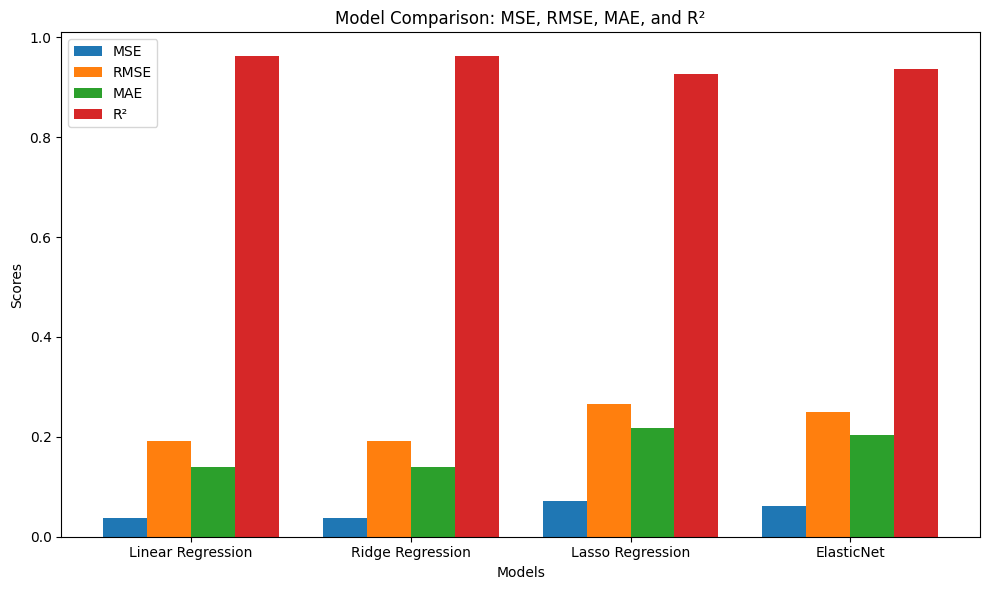

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'ElasticNet']

# Model metrics for comparison (MSE, RMSE, MAE, R²)
mse = [0.0367209874469416, 0.03672097725356385, 0.07054939944619033, 0.06187153929444625]
rmse = [0.191627209568322, 0.19162718297142461, 0.26561136919603107, 0.24873990289948705]
mae = [0.1403856673166202, 0.14038562689564069, 0.2186281006270146, 0.2034388400381749]
r2 = [0.9618702432405458, 0.9618702538249837, 0.9267440331146961, 0.9357548119576306]

# Bar width
bar_width = 0.2

# Set positions for each group of bars
index = np.arange(len(models))

# Create the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting each metric
ax.bar(index, mse, bar_width, label='MSE')
ax.bar(index + bar_width, rmse, bar_width, label='RMSE')
ax.bar(index + 2 * bar_width, mae, bar_width, label='MAE')
ax.bar(index + 3 * bar_width, r2, bar_width, label='R²')

# Labeling the graph
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Model Comparison: MSE, RMSE, MAE, and R²')
ax.set_xticks(index + 1.5 * bar_width)
ax.set_xticklabels(models)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [55]:
import joblib

# Save the final model (polynomial regression with linear regression)
joblib.dump(final_model, 'polynomial_regression_model.pkl')

# Optionally, save the best model with the optimal polynomial degree
joblib.dump(best_model, 'best_polynomial_regression_model.pkl')


['best_polynomial_regression_model.pkl']

In [58]:
import joblib

# Define the new path with the model name
model_save_path = '/content/drive/My Drive/ECommerce Analysis/TotalPricePredictionLinearRegression.pkl'

# Save the model with the new name
joblib.dump(final_model, model_save_path)

print(f"Model saved at {model_save_path}")



Model saved at /content/drive/My Drive/ECommerce Analysis/TotalPricePredictionLinearRegression.pkl


In [59]:
# Compute MSE, RMSE, MAE, R² for the final model
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

# Display test set performance
print("Final Model Test Set Performance:")
print(f"MSE: {mse_test}")
print(f"RMSE: {rmse_test}")
print(f"MAE: {mae_test}")
print(f"R²: {r2_test}")


Final Model Test Set Performance:
MSE: 0.016421997386077355
RMSE: 0.12814834133174474
MAE: 0.06380948949674689
R²: 0.9829479867135851


In [60]:
# Get coefficients for the final model (polynomial + linear regression)
coefficients = final_model.named_steps['linearregression'].coef_

# Get the feature names
features = final_model.named_steps['polynomialfeatures'].get_feature_names_out(X_train.columns)

# Create a DataFrame to view coefficients with their respective feature names
feature_importance = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients
})

# Sort by absolute value of the coefficients (to identify the most important features)
feature_importance['abs_coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='abs_coefficient', ascending=False)

# Display the top features
print(feature_importance)


                       Feature   Coefficient  abs_coefficient
1                 log_Quantity  1.076025e+00     1.076025e+00
2                log_UnitPrice  8.235209e-01     8.235209e-01
6   log_Quantity log_UnitPrice  1.006987e-01     1.006987e-01
9              log_UnitPrice^2 -4.969873e-02     4.969873e-02
5               log_Quantity^2 -2.652081e-02     2.652081e-02
3                    StockCode  1.411231e-05     1.411231e-05
11    log_UnitPrice CustomerID -3.372490e-06     3.372490e-06
7       log_Quantity StockCode  3.187838e-06     3.187838e-06
8      log_Quantity CustomerID -2.923970e-06     2.923970e-06
10     log_UnitPrice StockCode -1.875229e-06     1.875229e-06
4                   CustomerID -1.387447e-06     1.387447e-06
12                 StockCode^2 -2.753672e-09     2.753672e-09
14                CustomerID^2  8.499091e-11     8.499091e-11
13        StockCode CustomerID -4.761345e-13     4.761345e-13
0                            1  0.000000e+00     0.000000e+00


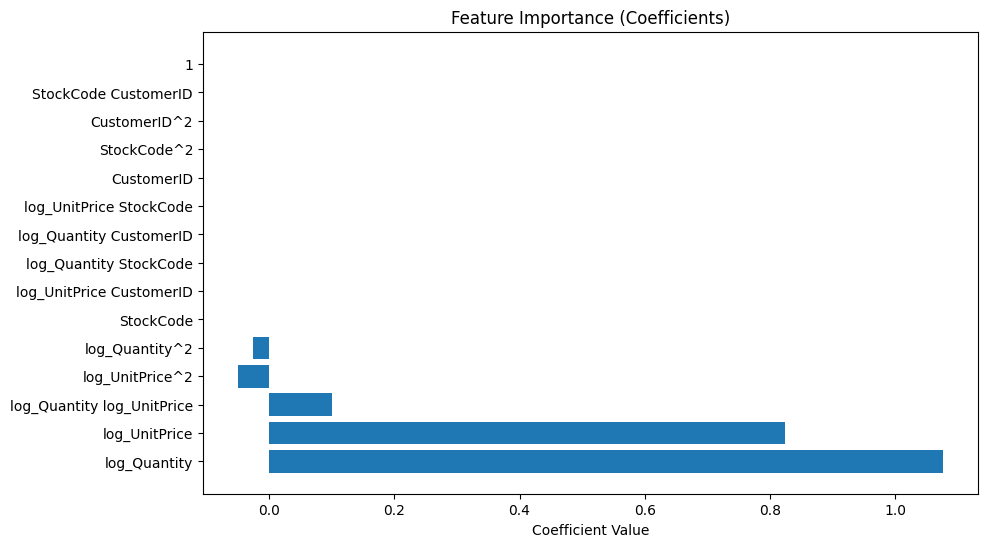

In [61]:
import matplotlib.pyplot as plt

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Feature Importance (Coefficients)')
plt.show()
